In [2]:

#%% Mount Google drive if you use colab for save and load files
if 'google.colab' in str(get_ipython()):
  colab = 1
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive')

  # Set your path on the google drive here for save and download files
  path = '/content/drive/MyDrive/Transformer_MPC/02_Surrogate/FOPDT/SISO/'
    
else:
  colab = 0
  print('Not running on Colab')
  path = ''

%xmode Verbose

Running on Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Exception reporting mode: Verbose


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pickle import dump, load
from sklearn.preprocessing import MinMaxScaler
import time


# For LSTM model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tqdm.keras import TqdmCallback

In [4]:
from scipy.integrate import odeint
from scipy.optimize import minimize

# Load NN models and Set the MPC horizons (window, P, and M) 

In [5]:
# Load NN model parameters and MinMaxScaler
model_params = load(open(path + 'model_param.pkl', 'rb'))
s1 = model_params['Xscale']
s2 = model_params['yscale']
window = model_params['window']

# Load NN models (onestep prediction models)
model_lstm = load_model(path + 'MPC_surrogate_SISO_FOPDT_LSTM.h5')
model_trans = load_model(path + 'MPC_surrogate_SISO_FOPDT_Transformer.h5')

# Load NN models (multistep prediction models)
model_lstm_multi = load_model(path + 'MPC_surrogate_SISO_FOPDT_multistep_LSTM.h5')
# model_lstm_multi = load_model(path + 'model.h5')
model_trans_multi = load_model(path + 'MPC_surrogate_SISO_FOPDT_multistep_Transformer.h5')

# Additional MPC parameter
P = 10 # Prediction Horizon
M = 4 # Control Horizon

# Process Model (FOPDT)

In [6]:
# Define process model (SISO FOPDT)
def process_model(y,t,u,K,tau):
    # arguments
    #  y   = outputs
    #  t   = time
    #  u   = input value
    #  K   = process gain
    #  tau = process time constant

    # calculate derivative
    dydt = (-y + K * u)/tau

    return dydt

# 1. MPC function with ODE model

In [7]:
def MPCobj_ode(u_hat, y_hat, SP_hat, t_hat, u, P, M):
  u_hat_P = np.ones(P-M) * u_hat[-1] # future u values after the control horizon(M)
  u_all = np.concatenate((u_hat, u_hat_P),axis=None)
  
  # FOPDT Parameters
  K=1      # gain
  tau=2    # time constant

  for i in range(0, t_hat.shape[0]-1):
    sol = odeint(process_model,y_hat[i],t_hat[i:i+2],args=(u_all[i],K,tau))
    y_hat[i+1] = sol[-1]
    # print(i)
    # print(t_hat[i:i+2])
    
    u_hat0 = np.append(u, u_hat)

  Obj = 10* np.sum((y_hat - SP_hat)**2) + np.sum(((u_hat0[1:] - u_hat0[0:-1])**2))

  pred_ode["y_hat"] = y_hat
  pred_ode["u_hat"] = u_all
  return Obj

In [8]:
# Values at time=k 
u = 0.5
y = 0.5
SP = 1

# Initial Values at time=k+ (prediction horizon) 
t_hat = np.linspace(0,P-1,P) # time steps in the prediction horizon (k+1 to k+P)
# u_hat = np.ones_like(t_hat) * u
u_hat = np.ones(M) * u # set the initial u values in the control horizon (M)
y_hat = np.ones_like(t_hat) * y # set the initial y values in the prediction horizon (P) 
SP_hat = np.ones_like(t_hat) * SP # set the setpoint values in the prediction horizon (P), same values throughout the P

# storage for the result
pred_ode = {
    "y_hat": np.ones_like(t_hat) * y,
    "u_hat":np.ones_like(t_hat) * u
    }

In [9]:
t0 = time.time()
solution = minimize(MPCobj_ode, u_hat, method='SLSQP',args=(y_hat, SP_hat, t_hat, u, P, M),options={'eps': 1e-08})
t1 = time.time()
Runtime_ode = t1-t0
print('Runtime: %.2f s' %(Runtime_ode))

Runtime: 0.06 s


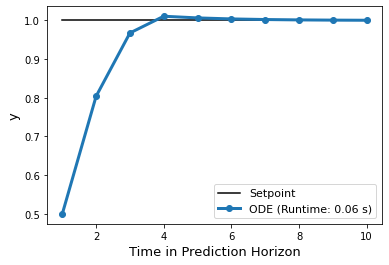

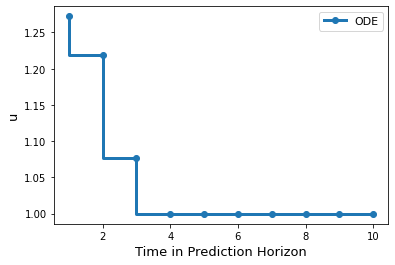

In [21]:
t_hat_plot = t_hat + 1 
plt.rcParams["font.family"] = "Times New Roman"
plt.figure()#figsize=(6.4, 9.6))
# plt.title("MPC calculation results using different models")
# plt.subplot(211)

plt.step(t_hat_plot, SP_hat,'k-',label='Setpoint')
plt.plot(t_hat_plot,pred_ode["y_hat"], 'o-', linewidth=3, label='ODE (Runtime: %.2f s)' %(Runtime_ode))
plt.ylabel('y', fontsize=13)
plt.xlabel('Time in Prediction Horizon', fontsize=13)
plt.legend(fontsize=11)

# plt.savefig(path + 'Onetime_MPC_calculation_result_CV.eps', format='eps')

# plt.subplot(212)
plt.figure()
plt.step(t_hat_plot,pred_ode["u_hat"], 'o-', linewidth=3, label='ODE')
plt.ylabel('u', fontsize=13)
plt.xlabel('Time in Prediction Horizon', fontsize=13)
plt.legend(fontsize=11)

# plt.savefig(path + 'Onetime_MPC_calculation_result_MV.eps', format='eps')

# 2. MPC function with LSTM model

In [10]:
def MPCobj_lstm(u_hat, y_hat, SP_hat, u, y, SP, window, P, M, multistep):
  u_hat_P = np.ones(P-M) * u_hat[-1] # future u values after the control horizon
  u_all = np.concatenate((u, u_hat, u_hat_P),axis=None)
  y_all = np.append(y, y_hat)

  # X = pd.DataFrame({'u': u_all, 'y':y_all})
  # Y = pd.DataFrame({'y': y_all})

  X = np.transpose([u_all,y_all]) 
  Y = np.transpose([y_all])
  SP_trans = np.transpose([SP_hat])

  Xs = s1.transform(X)
  Ys = s2.transform(Y)
  SPs = s2.transform(SP_trans)

  # Appending the window (past) and Prediction (future) arrays
  Xsq = Xs.copy()
  Ysq = Ys.copy()

  if multistep == 0:
    # SPsq = np.reshape(SP_pred, (P,Ys.shape[1]))
    for i in range(window,len(Xsq)):
        Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
        # LSTM prediction
        Xsq[i][(Xs.shape[1] - Ys.shape[1]):] = model_lstm(Xin) 
        # (Xs.shape[1]-Ys.shape[1]) indicates the index of the 
        # first 'system' output variable in the 'LSTM' input array
        Ysq[i] = Xsq[i][(Xs.shape[1] - Ys.shape[1]):]
  
  else:
    Xin = Xsq.reshape((1, window+P, np.shape(Xsq)[1]))
    Ysq = model_lstm_multi(Xin)


  Ytu = s2.inverse_transform(Ysq)
  Xtu = s1.inverse_transform(Xsq)

  u_hat0 = np.append(u[-1], u_hat)

  if multistep == 0:
    pred_lstm["y_hat"] = np.reshape(Ytu[window:], (1,P))[0]
    pred_lstm["u_hat"] = np.reshape(Xtu[window:,0], (1,P))[0]

    Obj = 10*np.sum((pred_lstm["y_hat"] - SP_hat)**2) + np.sum(((u_hat0[1:] - u_hat0[0:-1])**2))

  else:
    pred_lstm["y_hat_multi"] = Ytu[0]
    pred_lstm["u_hat_multi"] = Xtu[window:,0]
    
    Obj = 10*np.sum((pred_lstm["y_hat_multi"] - SP_hat)**2) + np.sum(((u_hat0[1:] - u_hat0[0:-1])**2))

  return Obj

In [11]:
# Values at time=k- (past)
u = np.ones(window) * 0.5
y = np.ones(window) * 0.5
SP = np.ones(window) * 1 # Setpoint

# Initial Values at time=k+ (in prediction horizon)
t_hat = np.linspace(0,P-1,P)
u_hat = np.ones(M) * u[-1]
y_hat = np.ones_like(t_hat) * y[-1]
SP_hat = np.ones_like(t_hat) * SP[-1]

pred_lstm = {
    "y_hat": np.ones_like(t_hat) * y[-1],
    "u_hat": np.ones_like(t_hat) * u[-1],
    "y_hat_multi": np.ones_like(t_hat) * y[-1],
    "u_hat_multi": np.ones_like(t_hat) * u[-1]
    }

In [12]:
pred_lstm['y_hat_multi']

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [13]:
# Control test for one-step prediction model (LSTM)
multistep = 0 
t0 = time.time()
solution = minimize(MPCobj_lstm, u_hat, method='SLSQP',args=(y_hat, SP_hat, u, y, SP, window, P, M, multistep),options={'eps': 1e-06, 'ftol': 1e-01})
t1 = time.time()
Runtime_lstm1 = t1-t0
print('Runtime (LSTM_Onestep): %.2f s' %(Runtime_lstm1))

Runtime (LSTM_Onestep): 13.48 s


In [14]:
# Control test for multi-step prediction model (LSTM)
multistep = 1 
t0 = time.time()
solution_multi = minimize(MPCobj_lstm, u_hat, method='SLSQP',args=(y_hat, SP_hat, u, y, SP, window, P, M, multistep),options={'eps': 1e-06, 'ftol': 1e-01})
t1 = time.time()
Runtime_lstm2 = t1-t0
print('Runtime (LSTM_Multistep): %.2f s' %(Runtime_lstm2))

Runtime (LSTM_Multistep): 2.44 s


#3. MPC function with Transformer model

In [15]:
def MPCobj_trans(u_hat, y_hat, SP_hat, u, y, SP, window, P, M, multistep):
  u_hat_P = np.ones(P-M) * u_hat[-1] # future u values after the control horizon
  u_all = np.concatenate((u, u_hat, u_hat_P),axis=None)
  y_all = np.append(y, y_hat)

  X = np.transpose([u_all,y_all]) 
  Y = np.transpose([y_all])
  SP_trans = np.transpose([SP_hat])

  Xs = s1.transform(X)
  Ys = s2.transform(Y)
  SPs = s2.transform(SP_trans)

  # Appending the window (past) and Prediction (future) arrays
  Xsq = Xs.copy()
  Ysq = Ys.copy()
  
  if multistep == 0:
    # SPsq = np.reshape(SP_pred, (P,Ys.shape[1]))
    for i in range(window,len(Xsq)):
        Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
        # LSTM prediction
        Xsq[i][(Xs.shape[1] - Ys.shape[1]):] = model_trans(Xin) 
        # (Xs.shape[1]-Ys.shape[1]) indicates the index of the 
        # first 'system' output variable in the 'LSTM' input array
        Ysq[i] = Xsq[i][(Xs.shape[1] - Ys.shape[1]):]
  
  else:
    Xin = Xsq.reshape((1, window+P, np.shape(Xsq)[1]))
    Ysq = model_trans_multi(Xin)
      
  Ytu = s2.inverse_transform(Ysq)
  Xtu = s1.inverse_transform(Xsq)

  u_hat0 = np.append(u[-1], u_hat)
  if multistep == 0:
    pred_trans["y_hat"] = np.reshape(Ytu[window:], (1,P))[0]
    pred_trans["u_hat"] = np.reshape(Xtu[window:,0], (1,P))[0]
    
    Obj = 10*np.sum((pred_trans["y_hat"] - SP_hat)**2) + np.sum(((u_hat0[1:] - u_hat0[0:-1])**2))

  else:
    pred_trans["y_hat_multi"] = Ytu[0]
    pred_trans["u_hat_multi"] = Xtu[window:,0]

    Obj = 10*np.sum((pred_trans["y_hat_multi"] - SP_hat)**2) + np.sum(((u_hat0[1:] - u_hat0[0:-1])**2))

  return Obj

In [16]:
# Values at time=k- (past)
u = np.ones(window) * 0.5
y = np.ones(window) * 0.5
SP = np.ones(window) * 1 # Setpoint

# Initial Values at time=k+ (in prediction horizon)
t_hat = np.linspace(0,P-1,P)
u_hat = np.ones(M) * u[-1]
y_hat = np.ones_like(t_hat) * y[-1]
SP_hat = np.ones_like(t_hat) * SP[-1]

pred_trans = {
    "y_hat": np.ones_like(t_hat) * y[-1],
    "u_hat": np.ones_like(t_hat) * u[-1],
    "y_hat_multi": np.ones_like(t_hat) * y[-1],
    "u_hat_multi": np.ones_like(t_hat) * u[-1]
    }

In [17]:
np.ones(P-M) * u_hat[-1]

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [18]:
# Control test for one-step prediction model (Transformer)
t0 = time.time()
multistep = 0
solution = minimize(MPCobj_trans, u_hat, method='SLSQP',args=(y_hat, SP_hat, u, y, SP, window, P, M, multistep),options={'eps': 1e-06, 'ftol': 1e-01})
t1 = time.time()
Runtime_trans1 = t1-t0
print('Runtime (Transformer_onestep): %.2f s' %(Runtime_trans1))

Runtime (Transformer_onestep): 4.12 s


In [19]:
# Control test for multi-step prediction model (Transformer)
multistep = 1 
t0 = time.time()
solution_multi = minimize(MPCobj_trans, u_hat, method='SLSQP',args=(y_hat, SP_hat, u, y, SP, window, P, M, multistep),options={'eps': 1e-06, 'ftol': 1e-01})
t1 = time.time()
Runtime_trans2 = t1-t0
print('Runtime (Transformer_multistep): %.2f s' %(Runtime_trans2))

Runtime (Transformer_multistep): 0.65 s


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


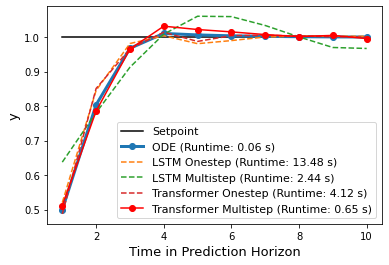

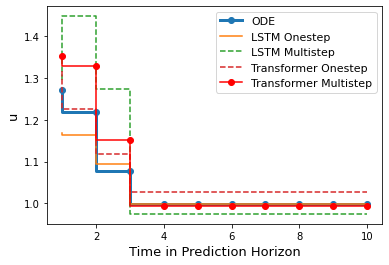

In [20]:
t_hat_plot = t_hat + 1 
plt.rcParams["font.family"] = "Times New Roman"
plt.figure()#figsize=(6.4, 9.6))
# plt.title("MPC calculation results using different models")
# plt.subplot(211)

plt.step(t_hat_plot, SP_hat,'k-',label='Setpoint')
plt.plot(t_hat_plot,pred_ode["y_hat"], 'o-', linewidth=3, label='ODE (Runtime: %.2f s)' %(Runtime_ode))
plt.plot(t_hat_plot,pred_lstm["y_hat"], '--', label='LSTM Onestep (Runtime: %.2f s)' %(Runtime_lstm1))
plt.plot(t_hat_plot,pred_lstm["y_hat_multi"], '--',label='LSTM Multistep (Runtime: %.2f s)' %(Runtime_lstm2))
plt.plot(t_hat_plot,pred_trans["y_hat"], '--', label='Transformer Onestep (Runtime: %.2f s)' %(Runtime_trans1) )
plt.plot(t_hat_plot,pred_trans["y_hat_multi"], 'ro-', linewidth=1.5, label='Transformer Multistep (Runtime: %.2f s)' %(Runtime_trans2))
plt.ylabel('y', fontsize=13)
plt.xlabel('Time in Prediction Horizon', fontsize=13)
plt.legend(fontsize=11)

# plt.savefig(path + 'Onetime_MPC_calculation_result_CV.eps', format='eps')

# plt.subplot(212)
plt.figure()
plt.step(t_hat_plot,pred_ode["u_hat"], 'o-', linewidth=3, label='ODE')
plt.step(t_hat_plot,pred_lstm["u_hat"], label='LSTM Onestep')
plt.step(t_hat_plot,pred_lstm["u_hat_multi"], '--',label='LSTM Multistep')
plt.step(t_hat_plot,pred_trans["u_hat"], '--', label='Transformer Onestep')
plt.step(t_hat_plot,pred_trans["u_hat_multi"], 'ro-', linewidth=1.5, label='Transformer Multistep')
plt.ylabel('u', fontsize=13)
plt.xlabel('Time in Prediction Horizon', fontsize=13)
plt.legend(fontsize=11)

# plt.savefig(path + 'Onetime_MPC_calculation_result_MV.eps', format='eps')